# this notebook processes raw detector images into 1D (intensity vs q) and saves in a data frame for all scans in an experiemtn

In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook
from matplotlib import ticker
import path
import datetime
import csv
import os
import pandas as pd
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ConstantModel


# data-handling
from glob import glob

# pyFAI
from pyFAI.multi_geometry import MultiGeometry 
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.goniometer import GeometryTranslation
from pyFAI.goniometer import GoniometerRefinement
from pyFAI.goniometer import Goniometer
import pyFAI
#from pyFAI.multi_geometry import GeometryTranslation, GoniometerRefinement, Goniometer, Multigeometry
from pyFAI.calibrant import get_calibrant
from pyFAI.gui import jupyter
import fabio

ERROR:fabio.nexus:h5py module missing
ERROR:pyFAI.io:h5py module missing


In [2]:
#importing information and data from experiment

#diffraction data
#calibration
calibration_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\LaB6\\images\\imgs"
calibration_function = os.path.join(calibration_folder, "Lab6calib.json")

#experiment
filename = "cell4"
expt_folder =  "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\cell4"
name_raw_folder = expt_folder + "\\images"



#images_folder = expt_folder + name_raw_folder
saved_1d_data = expt_folder + "\\1D_Data"
saved_figures = expt_folder + "\\saved_figures"

csv_format = filename + "_scan"
sample_csv = filename + "_scan1.csv"
image_format = "b_toney_" + filename + "_scan"

#make folders to put 1D Q vs intensity csvs and figures if they aren't there yet
if not os.path.exists(saved_1d_data):
    os.makedirs(saved_1d_data)

if not os.path.exists(saved_figures):
    os.makedirs(saved_figures)

#detector params for read raw
w = 1475
h = 195
npt = 500 #number of points in integration
scanlist = filename
npt = 400

#echem 
echem_folder = "H:\\Data\\ProjectsandData\\LiXRD\\open cell\\cone cell\\20190329\\echem"
date_formatec = '%m/%d/%Y %H:%M:%S.%f'

#spec inputs
date_format = '%b %d %H:%M:%S %Y'


cell4_2p0mA_1cyc_5hr_C01.txt
Index(['Ns', 'time/s', 'Ewe/V', '<I>/mA', 'Capacity/mA.h', 'Energy charge/W.h',
       'Energy discharge/W.h', 'Q discharge/mA.h', 'Q charge/mA.h',
       'Unnamed: 9'],
      dtype='object')


<IPython.core.display.Javascript object>


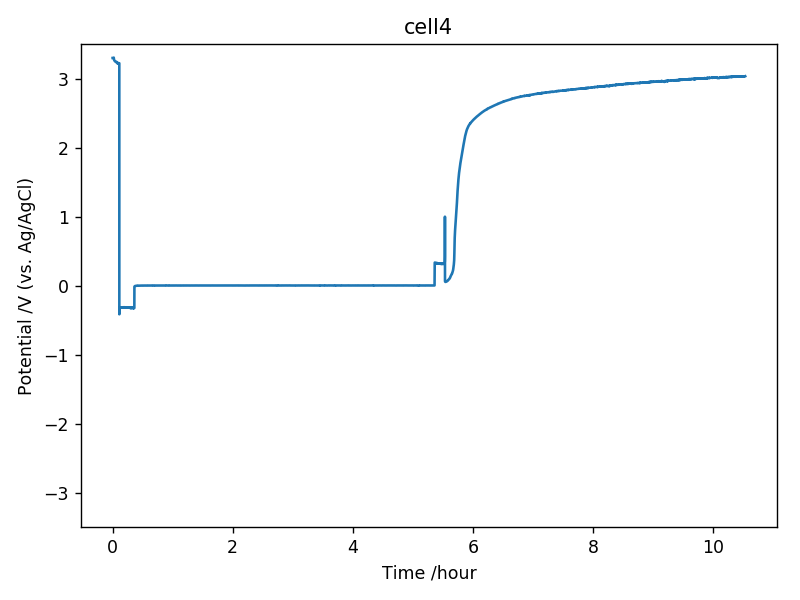

<IPython.core.display.Javascript object>


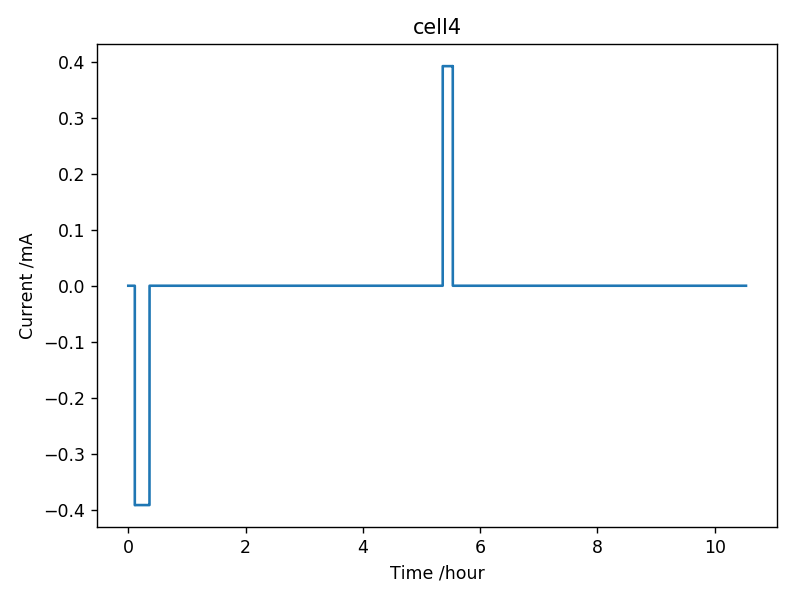

2019-03-31 10:52:15.000200 2019-03-31 21:24:15.028400


In [3]:
#get echem data
os.chdir(echem_folder)
echem_filename = glob("*" + filename + "*.txt")
echem_file = echem_filename[0]
print(echem_file)


ec_data = pd.read_csv(echem_file, delimiter='\t')
print(ec_data.columns)
time_abs  = ec_data['time/s']
potential = ec_data['Ewe/V']
current   = ec_data['<I>/mA']


start_time = time_abs[0]
last = len(time_abs)-1
end_time = time_abs[last]

#convert the strings that represent the time to a time that python understands and then to a time delta
time_translated = (pd.to_datetime(time_abs, format=date_formatec))

#find the start and end times
start_time = time_translated[0]
last =   len(time_translated)-1
end_time =   time_translated[last]

#convert time into time since beginning of expt
time_delta = pd.to_timedelta(time_translated - start_time) / np.timedelta64(1, 's')
plt.figure(1)
plt.plot(time_delta/3600, potential)
plt.xlabel("Time /hour")
plt.ylabel("Potential /V (vs. Ag/AgCl)")
plt.ylim(-3.5, 3.5)
plt.title(filename)
plt.gcf()
plt.tight_layout()
os.chdir(saved_figures)
plt.savefig('potential vs time')
plt.show()

plt.figure(2)
plt.plot(time_delta/3600, current)
plt.xlabel("Time /hour")
plt.ylabel("Current /mA")
plt.title(filename)
plt.show()
plt.gcf()
plt.tight_layout()
os.chdir(saved_figures)
plt.savefig('current vs time')
print(start_time, end_time)

In [4]:
#input geometry/detector configuration and calibration

os.chdir(calibration_folder)
translate_tth = Goniometer.sload(calibration_function)
print('tth',translate_tth)

tth Goniometer with param GonioParam(dist=0.9020216565148867, poni1=0.014428575357034257, poni2=0.1048631600805778, rot1=-0.0591671570142037, rot1_scale=1.8444850294528535e-05, rot2_offset=0.0001462651610299592, rot2_scale=0.017445985605733502, rot3=3.994463710745674e-09, rot3_scale=2.5697445740163045e-09)    
 with Detector Pilatus 300kw	 PixelSize= 1.720e-04, 1.720e-04 m


In [5]:
def read_raw_pilatus(fn, w, h):
    try:
        with open(fn, 'r') as f:
            img = np.fromfile(f, dtype=np.int32)
        img = np.reshape(img, (h,w), order='C')
        #img = img.T
        return img
    except:
        print("Error reading file: %s" % fn)
        return(None)


#gets angles and mon from csv file
def get_csv_info(scanname):
    #Takes the basename (b_toney_scanname_scan1) and returns the angles of the detector in all scans by looking up in the csv file
    csvfile = scanname
    csv_df = pd.read_csv(csvfile, delimiter=',', encoding="utf-8-sig")
    #print(csv_df.columns)
    #angles = csv_df['       tth']
    mons = csv_df['  Monitor']
    
    return mons

os.chdir(expt_folder)
print(os.getcwd())
monitor = get_csv_info(sample_csv)

print("Inputs check, are these correct?")
print("monitor value:", monitor)
#print("tth angles:", angles)

H:\Data\ProjectsandData\LiXRD\open cell\cone cell\20190329\cell4
Inputs check, are these correct?
monitor value: 0     1.31220
1     1.31117
2     1.31955
3     1.32402
4     1.32094
5     1.32385
6     1.32743
7     1.32870
8     1.32826
9     1.32847
10    1.32907
11    1.32123
12    1.31593
13    1.32958
14    1.33067
15    1.32871
16    1.33129
17    1.33277
18    1.33146
19    1.33248
20    1.33171
21    1.33420
22    1.33399
23    1.33355
24    1.33356
25    1.33363
26    1.33417
27    1.33136
28    1.33633
29    1.33449
30    1.33421
31    1.33464
32    1.33954
33    1.34278
34    1.34490
35    1.34592
36    1.34473
37    1.34457
38    1.34424
39    1.34487
40    1.34199
41    1.34569
42    1.34636
43    1.34533
44    1.34650
45    1.34666
46    1.34420
47    1.34574
48    1.34199
49    1.34585
50    1.34427
Name:   Monitor, dtype: float64


In [6]:
%matplotlib notebook

#creates list of scans and times from spec file
os.chdir(expt_folder)
with open(filename, 'r') as fout:
    specfile = fout.readlines()
    
i = 0
scans_Li = []
scans_LiF = []
times_Li = []
times_LiF = []
scans_full = []
times_full = []

for i, line in enumerate(specfile):
    if "#E" in specfile[i]:
        split_epochline = (line.split())
        epoch_start = split_epochline[1]
        print('Epoch=', epoch_start)
    if "#S" in specfile[i]:
        try: 
            split_scanline = (specfile[i].split())
            scan_no = int(split_scanline[1])
            #print(scan_no)
            scan_type = split_scanline[2]
            #print(scan_type)
            if scan_type == "ascan":    
                split_angle_line = (specfile[i+8].split())
                angle = split_angle_line[1]
                
                if float(angle) == 22.5:
                    scans_LiF.append(scan_no)
                    split_timeline = (specfile[i+23].split())
                    times_LiF.append(float(split_timeline[5]))
                
                if float(angle) == 19.8:
                    scans_Li.append(scan_no)
                    split_timeline = (specfile[i+23].split())
                    times_Li.append(float(split_timeline[4]))
            if scan_type == "a2scan":
                scans_full.append(scan_no)
                split_timeline = (specfile[i+23].split())
                times_full.append(float(split_timeline[5]))
        except:
            print("problem with scan#", split_scanline[1])
print(scans_Li[0:50])
print(times_Li[0:50])
print(scans_full)               
  

Epoch= 1554054788
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[192.48, 206.966, 223.451, 237.865, 254.417, 268.895, 285.386, 299.834, 316.382, 330.852, 347.38, 361.872, 378.385, 392.852, 409.43, 423.895, 440.492, 455.054, 471.514, 485.981, 502.763, 517.368, 533.971, 548.388, 564.886, 579.326, 595.794, 610.23, 626.759, 641.203, 657.707, 672.134, 688.637, 703.089, 719.611, 734.382, 750.942, 765.414, 781.908, 796.419, 812.919, 827.576, 844.03, 858.509, 875.045, 889.587, 906.039, 920.513, 937.124, 951.642]
[1, 202, 403, 604, 805, 1006, 1207, 1408, 1609, 1810, 2011, 2212]


In [8]:
angles = [19.8]       
%matplotlib notebook
data = []
scans_processed = []
times_scans_processed = []

for n, scan_no in enumerate(scans_Li):
    #get angles and monitor counts during scan from csv file
    print(scan_no)
    os.chdir(expt_folder)
    csv = glob("*" + filename + "_scan" + str(scan_no) + ".csv")
    #print(csv)
    monitor = get_csv_info(csv[0])
    #print(monitor)
    if all(v != 0 for v in monitor):
        #find images within scan
        os.chdir(name_raw_folder)
        images_list = glob("*" + filename + "_scan" + str(scan_no) + "_*.raw")
        images_list = np.array(images_list)
        #print(images_list)
        images = [] #list of scans to integrate (for single angle this should have one items - the summed scans)
        img_sum = np.zeros((h,w)) #empty array to add the individual scans at 11 point into
        scans_processed.append(scan_no)
        times_scans_processed.append(times_Li[n])
        for i, image_l in enumerate(images_list):
            
            os.chdir(name_raw_folder)
            #print(os.listdir())
            image = read_raw_pilatus(image_l, w, h)
            #print(np.shape(image))
            image_norm_to_mon = image/monitor[i]
            #print(np.shape(image_norm_to_mon))
            #print(monitor[i])
            img_sum = img_sum + image_norm_to_mon
            #print(np.shape(img_sum))
        images.append(img_sum)
        #print(angles)
        #integrate multiple images in scan
        multigeo = translate_tth.get_mg(angles)
        multigeo.radial_range=(2.1,2.77)
        multigeo.unit="q_A^-1"
        #print(multigeo)
        tth,intensity  = multigeo.integrate1d(images, npt)
        os.chdir(saved_1d_data)
        df = pd.DataFrame(tth, intensity)
        df.to_csv(str(scan_no)+'.csv')
        data.append([intensity])
    else:
        print('blank image', scan_no)
        
        
        
    
    
    
#####DO NOT RE-RUN HERE
data = np.reshape(data, (-1, npt))
indices = [np.array(scans_processed), np.array(times_scans_processed)]
    
experiment_df = pd.DataFrame(data, index=indices, columns = tth)
#print(experiment_df)
os.chdir(saved_1d_data)
experiment_df.to_csv(filename + 'total_experiment_df.csv')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
blank image 47
48
blank image 48
49
50
blank image 50
51
blank image 51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
26

1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058


In [ ]:
print(times_Li)
print('hi')
print(np.shape(data))
data = np.reshape(data, (-1, npt))

indices = [np.array(scans_processed), np.array(times_Li)]

experiment_df = pd.DataFrame(data, index=indices, columns = tth)
#print(experiment_df)
os.chdir(saved_1d_data)
experiment_df.to_csv(filename + 'total_experiment_df.csv')

In [ ]:
os.chdir(saved_1d_data)
data = []
for n, scan_no in enumerate(scans_Li[0:1]):
    #print(scan_no)
    df = pd.read_csv(str(scan_no)+'.csv',  header=[0,1])
    print(df[])
    q = df[0]
    
    print(df.unstack)
indices = [np.array(scans_Li), np.array(times_Li)]
print(q)    
experiment_df = pd.DataFrame(data, index=indices, columns = q)
#print(experiment_df)
os.chdir(saved_1d_data)
experiment_df.to_csv('total_experiment_df.csv')

In [9]:
data = np.reshape(data, (len(scans_Li), npt))
#data = np.flipud(data)
indices = [np.array(scans_Li), np.array(times_Li)]
start_scans = min(time_delta) + float(times_Li[3]) ###this needs to change
end_scans   = max(time_delta) + float(times_Li[3])
print(start_scans, end_scans)

experiment_df = pd.DataFrame(data, index=indices, columns = tth)
#print(experiment_df)
os.chdir(saved_1d_data)
experiment_df.to_csv('total_experiment_df-b.csv')

"""#cut out data before and after echem started
cut_experiment_df = experiment_df.loc[(slice(None),slice(start_scans, end_scans)),:]
os.chdir(saved_1d_data)
cut_experiment_df.to_csv('during_echem_experiment_df.csv')
print(np.shape(cut_experiment_df))"""

0.4 37920.4282


"#cut out data before and after echem started\ncut_experiment_df = experiment_df.loc[(slice(None),slice(start_scans, end_scans)),:]\nos.chdir(saved_1d_data)\ncut_experiment_df.to_csv('during_echem_experiment_df.csv')\nprint(np.shape(cut_experiment_df))"

In [ ]:

first_scan_in_expt = cut_experiment_df.axes[0][0][1]
last_scan_in_expt  = cut_experiment_df.axes[0][-1][1]
print(last_scan_in_expt, first_scan_in_expt)

plt.figure(3, figsize=(7,5))
gs = gridspec.GridSpec(1,2, width_ratios=[3,1])
gs.update(wspace=0.025)
axE = plt.subplot(gs[0]) #subplot for echem
axE.imshow(((cut_experiment_df.values)), interpolation = 'none', aspect = 'auto', extent=(min(tth), max(tth), last_scan_in_expt-first_scan_in_expt, 0))
axE.set_xlabel('Two Theta /deg at 14 keV')
axE.set_ylabel('Time /sec')

axX = plt.subplot(gs[1]) #subplot of XRD
axX.plot(current, time_delta, 'C0')
axX.set_xlabel('Current /mA')
axX2 = axX.twiny()
axX2.plot(potential, time_delta, 'C1')
axX2.set_xlabel('Potential /V (vs. Ag/AgCl)')
axX.set_ylim(max(time_delta),0)
axX.set_yticks([])
plt.show()

plt.gcf()
plt.tight_layout
os.chdir(saved_figures)
plt.savefig('waterfall with echem')

In [ ]:
#cut interesting 2 theta range
low_tth_bound = 8.5
high_tth_bound = 23.8
cut_tth_df = cut_experiment_df.loc[:,(slice(low_tth_bound, high_tth_bound))]
os.chdir(saved_1d_data)
cut_tth_df.to_csv('tth_cut_experiment_df.csv')
print(cut_tth_df.columns[0])

first_tth_in_expt = cut_tth_df.columns[0]
last_tth_in_expt  = cut_tth_df.columns[-1]
first_scan_in_expt = cut_tth_df.axes[0][0][1]
last_scan_in_expt  = cut_tth_df.axes[0][-1][1]
print(last_tth_in_expt, first_tth_in_expt)

plt.figure(4, figsize=(7,5))
gs = gridspec.GridSpec(1,2, width_ratios=[3,1])
gs.update(wspace=0.025)
axE = plt.subplot(gs[0]) #subplot for echem
axE.imshow(((cut_tth_df.values)), interpolation = 'none', aspect = 'auto', extent=( first_tth_in_expt,last_tth_in_expt, last_scan_in_expt-first_scan_in_expt, 0))
axE.set_xlabel('Two Theta /deg at 14 keV')
axE.set_ylabel('Time /sec')

axX = plt.subplot(gs[1]) #subplot of XRD
axX.plot(current, time_delta, 'C0')
axX.set_xlabel('Current /mA')
axX2 = axX.twiny()
axX2.plot(potential, time_delta, 'C1')
axX2.set_xlabel('Potential /V (vs. Ag/AgCl)')
axX.set_ylim(max(time_delta),0)
axX.set_yticks([])
plt.show()

plt.gcf()
plt.tight_layout
os.chdir(saved_figures)
plt.savefig('waterfall cut tth with echem')

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook
#print(np.shape(data))
data = np.array(data)
intensities = data[:,:]
print(np.shape(intensities))
plt.figure(0)
plt.imshow((intensities), vmin = 1000000000, vmax = 20000000000, interpolation = 'none', aspect = 'auto', extent=(min(tth), max(tth), max(scans_Li), min(scans_Li)))
plt.show();

plt.gcf()
plt.tight_layout
os.chdir(saved_figures)
plt.savefig('waterfall totalnorm')


In [ ]:
for n, scan_no in enumerate(scans_Li[800:801]):
    #get angles and monitor counts during scan from csv file
    print(scan_no)
    os.chdir(saved_1d_data)
    csv = glob(str(scan_no) + ".csv")

    tth,i  = multigeo.integrate1d(images, npt)
    os.chdir(saved_1d_data)
    df = pd.DataFrame(tth, i)
    df.to_csv(str(scan_no)+'.csv')
    data.append([i])